# 2D indentation using Argiope & Hardness



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!cat local_settings.py.example

# LOCAL SETTINGS
# Modify as needed and rename local_settings.py
GMSH_PATH    = "gmsh"
ABAQUS_PATH  = "abaqus" 


In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import hardness as hd
import argiope as ag
import pandas as pd
import numpy as np
import os, subprocess, time, local_settings, time
%matplotlib nbagg

mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['contour.negative_linestyle'] = 'solid'

# USEFUL FUNCTIONS
def create_dir(path):
  try:
    os.mkdir(path)
  except:
    pass

## Settings

In [4]:
# SETTINGS
workdir   = "_workdir/"
outputdir = "outputs/"
label   = "indentation_2D"

create_dir(workdir)
create_dir(workdir + outputdir)     

## Model definition

In [5]:
#-------------------------------------------------------------------------------
# MESH DEFINITIONS
def element_map(mesh):
    mesh.elements.loc[mesh.elements.type.argiope == "tri3", ("type", "solver", "")] = "CAX3" 
    mesh.elements.loc[mesh.elements.type.argiope == "quad4", ("type", "solver", "")] = "CAX4R" 
    return mesh
    
    
def sample_material_map(mesh):
    mesh.elements["materials"] = "SAMPLE_MAT" 
    return mesh

def indenter_material_map(mesh):
    mesh.elements["materials"] = "INDENTER_MAT" 
    return mesh
    
    
parts = {
    "sample" : hd.models.Sample2D(lx = 1., ly = 1., 
                                   r1 = 2., r2 = 3., 
                                   Nx = 32, Ny = 16,
                                   Nr = 2, Nt = 64, 
                                   gmsh_path = "gmsh",
                                   file_name = "dummy", 
                                   workdir = workdir, 
                                   gmsh_space = 2, 
                                   gmsh_options = "-algo 'delquad'",
                                   element_map = element_map,
                                   material_map = sample_material_map),
                                   
    "indenter" : hd.models.SpheroconicalIndenter2D(
                                   R = 1.,
                                   psi= 70.3, 
                                   r1 = 1., 
                                   r2 = 3., 
                                   r3 = 4., 
                                   lc1 = .05, 
                                   lc2 = .5,
                                   rigid = False,
                                   gmsh_path = "gmsh",
                                   file_name = "dummy", 
                                   workdir = workdir, 
                                   gmsh_space = 2, 
                                   gmsh_options = "-algo 'delquad'",
                                   element_map = element_map,
                                   material_map = indenter_material_map)}
                                   
materials = [ag.materials.Hollomon(label = "SAMPLE_MAT", strain_data_points = 100),
             ag.materials.Hollomon(label = "INDENTER_MAT", strain_data_points = 100)]

#-------------------------------------------------------------------------------
# STEP DEFINTIONS
steps = [
        hd.models.Step2D(name = "LOADING1",
                         control_type = "disp", 
                         duration = 1.,
                         kind = "adaptative",  
                         nframes = 50,
                         controlled_value = -0.2,
                         field_output_frequency = 99999),
        hd.models.Step2D(name = "UNLOADING1",
                         control_type = "force", 
                         duration = 1.,
                         kind = "adaptative",  
                         nframes = 50,
                         controlled_value = 0.,
                         field_output_frequency = 99999),
        hd.models.Step2D(name = "RELOADING1",
                         control_type = "disp", 
                         duration = 1.,
                         kind = "adaptative",  
                         nframes = 50,
                         controlled_value = -0.2,
                         field_output_frequency = 99999),
        hd.models.Step2D(name = "LOADING2",
                         control_type = "disp", 
                         duration = 1.,
                         kind = "adaptative",  
                         nframes = 50,
                         controlled_value = -0.4,
                         field_output_frequency = 99999),                                    
        hd.models.Step2D(name = "UNLOADING2",
                         control_type = "force",
                         kind = "adaptative", 
                         duration = 1., 
                         nframes = 50,
                         controlled_value = 0.,
                         field_output_frequency = 99999)
        ]                                                                                                  

model0 = hd.models.Indentation2D(label = label, 
                      parts = parts, 
                      steps = steps, 
                      materials = materials, 
                      solver = "abaqus", 
                      solver_path = local_settings.ABAQUS_PATH,
                      workdir = workdir,
                      verbose = True)



In [6]:
print("1: Preprocessing ----------------------------------")
%time model0.write_input()
print("2: Processing -------------------------------------")
%time model0.run_simulation()
print("3: Postprocessing ---------------------------------")
%time model0.postproc()
print("4: Saving model -----------------------------------")
%time model0.save(workdir + "model.pcklz")

1: Preprocessing ----------------------------------
CPU times: user 1.66 s, sys: 16 ms, total: 1.68 s
Wall time: 3.96 s
2: Processing -------------------------------------
<Running "indentation_2D" using abaqus>
(b'Abaqus JOB indentation_2D\nAbaqus 6.13-1\nBegin Analysis Input File Processor\nThu Feb  1 22:16:08 2018\nRun pre\nThu Feb  1 22:16:15 2018\nEnd Analysis Input File Processor\nBegin Abaqus/Standard Analysis\nThu Feb  1 22:16:15 2018\nRun standard\nThu Feb  1 22:17:54 2018\nEnd Abaqus/Standard Analysis\nAbaqus JOB indentation_2D COMPLETED\n', None)
<Ran indentation_2D: duration 123.90s>
CPU times: user 8 ms, sys: 8 ms, total: 16 ms
Wall time: 2min 3s
3: Postprocessing ---------------------------------
<Post-Processing"indentation_2D" using abaqus>
/opt/abaqus/scratch/Commands/abaqus viewer noGUI=indentation_2D_abqpp.py
(b'', None)
<Post-Processed indentation_2D: duration 14.62s>
CPU times: user 416 ms, sys: 12 ms, total: 428 ms
Wall time: 15.2 s
4: Saving model ---------------

In [8]:
model = ag.utils.load(workdir + "model.pcklz")

## Model checking

Mesh building and quality checking.

In [9]:
parts["indenter"].mesh.elements.head()

conn                    materials         sets    type         \
          n0   n1   n2   n3               ALL_ELEMENTS argiope solver   
                                                                        
element                                                                 
79       480  461  453  447  INDENTER_MAT         True   quad4  CAX4R   
80       262  323  318  290  INDENTER_MAT         True   quad4  CAX4R   
81       251  273  318  274  INDENTER_MAT         True   quad4  CAX4R   
82       487  471  461  480  INDENTER_MAT         True   quad4  CAX4R   
83        34   35  100   91  INDENTER_MAT         True   quad4  CAX4R   

        surfaces                       
         SURFACE                       
              f1     f2     f3     f4  
element                                
79         False  False  False  False  
80         False  False  False  False  
81         False  False  False  False  
82         False  False  False  False  
83          True  False  False  False

In [12]:
parts["sample"].mesh.elements.head()

conn                  materials  sets                  type         \
          n0   n1   n2   n3              CORE SHELL1 SHELL2 argiope solver   
                                                                             
element                                                                      
161        1    9  273  100  SAMPLE_MAT  True  False  False   quad4  CAX4R   
162      100  273  274   99  SAMPLE_MAT  True  False  False   quad4  CAX4R   
163       99  274  275   98  SAMPLE_MAT  True  False  False   quad4  CAX4R   
164       98  275  276   97  SAMPLE_MAT  True  False  False   quad4  CAX4R   
165       97  276  277   96  SAMPLE_MAT  True  False  False   quad4  CAX4R   

                sets surfaces                      
        ALL_ELEMENTS  SURFACE                      
                           f1     f2     f3    f4  
element                                            
161             True    False  False  False  True  
162             True    False  False  False  True  
163             True    False  False  False  True  
164             True    False  False  False  True  
165             True    False  False  False  True

<IPython.core.display.Javascript object>


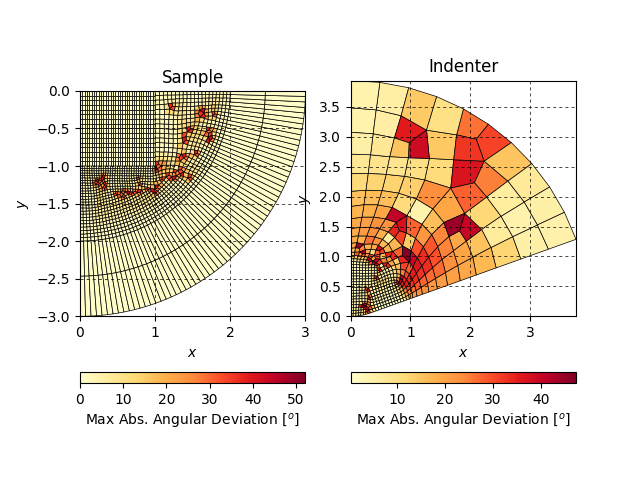

In [13]:
i = 1
fig = plt.figure()
parts_names = parts.keys()
for name, part in parts.items(): 
    mesh = part.mesh
    patches = mesh.to_polycollection(edgecolor = "black", linewidth = .5, alpha = 1.)
    stats = mesh.stats()
    patches.set_array( stats.stats.max_abs_angular_deviation )
    patches.set_cmap(mpl.cm.YlOrRd)
    ax = fig.add_subplot(1, 2, i)
    ax.set_aspect("equal")
    ax.set_xlim(mesh.nodes.coords.x.min(), mesh.nodes.coords.x.max())
    ax.set_ylim(mesh.nodes.coords.y.min(), mesh.nodes.coords.y.max())
    ax.add_collection(patches)
    cbar = plt.colorbar(patches, orientation = "horizontal")
    cbar.set_label("Max Abs. Angular Deviation [$^o$]")
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.grid()
    plt.title(name.title())
    i+= 1
plt.show()


## Simulation

## Post-Processing

### Time data


In [14]:
hist = model.data["history"]
hist.head()

,Wes,Wf,RF,Wtot,dtot,dtip,Wei,CF,Wps,t,step,F
0,0.000000e+00,0.0,-0.000000,0.000000e+00,0.000,0.000000,0.000000e+00,0.0,0.000000e+00,0.00,0,0.000000
1,1.212877e-07,0.0,-0.000172,4.422799e-07,-0.004,-0.001551,1.233546e-07,0.0,0.000000e+00,0.02,0,-0.000172
2,6.669946e-07,0.0,-0.000491,1.847205e-06,-0.008,-0.003299,6.782098e-07,0.0,6.062493e-08,0.04,0,-0.000491
3,1.686836e-06,0.0,-0.000875,4.664735e-06,-0.012,-0.004649,1.736839e-06,0.0,3.638050e-07,0.06,0,-0.000875
4,3.280809e-06,0.0,-0.001326,9.065953e-06,-0.016,-0.006779,3.380591e-06,0.0,9.305143e-07,0.08,0,-0.001326


<IPython.core.display.Javascript object>


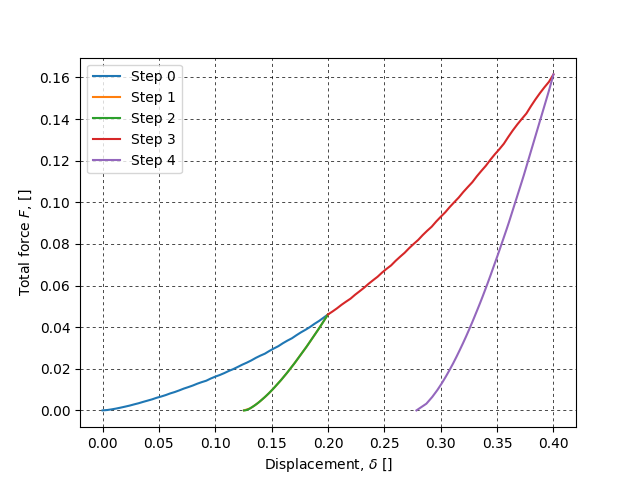

In [15]:
plt.figure()
for step, group in hist.groupby("step"):
  plt.plot(-group.dtot, -group.F, label = "Step {0}".format(step))
plt.grid()
plt.legend(loc = "best")
plt.ylabel("Total force $F$, []")
plt.xlabel("Displacement, $\delta$ []")
plt.show()

### Fields

In [16]:
model.parts["sample"].mesh.fields_metadata()

,frame,frame_value,label,part,position,step_label,step_num
0,0,0,S,I_SAMPLE,node,LOADING1,0
1,0,0,U,I_SAMPLE,node,LOADING1,0
2,1,1,S,I_SAMPLE,node,LOADING1,0
3,1,1,U,I_SAMPLE,node,LOADING1,0
4,0,0,S,I_SAMPLE,node,UNLOADING1,1
5,0,0,U,I_SAMPLE,node,UNLOADING1,1
6,1,1,S,I_SAMPLE,node,UNLOADING1,1
7,1,1,U,I_SAMPLE,node,UNLOADING1,1
8,0,0,S,I_SAMPLE,node,RELOADING1,2
9,0,0,U,I_SAMPLE,node,RELOADING1,2


In [17]:
model.parts["sample"].mesh.fields_metadata()

,frame,frame_value,label,part,position,step_label,step_num
0,0,0,S,I_SAMPLE,node,LOADING1,0
1,0,0,U,I_SAMPLE,node,LOADING1,0
2,1,1,S,I_SAMPLE,node,LOADING1,0
3,1,1,U,I_SAMPLE,node,LOADING1,0
4,0,0,S,I_SAMPLE,node,UNLOADING1,1
5,0,0,U,I_SAMPLE,node,UNLOADING1,1
6,1,1,S,I_SAMPLE,node,UNLOADING1,1
7,1,1,U,I_SAMPLE,node,UNLOADING1,1
8,0,0,S,I_SAMPLE,node,RELOADING1,2
9,0,0,U,I_SAMPLE,node,RELOADING1,2


<IPython.core.display.Javascript object>


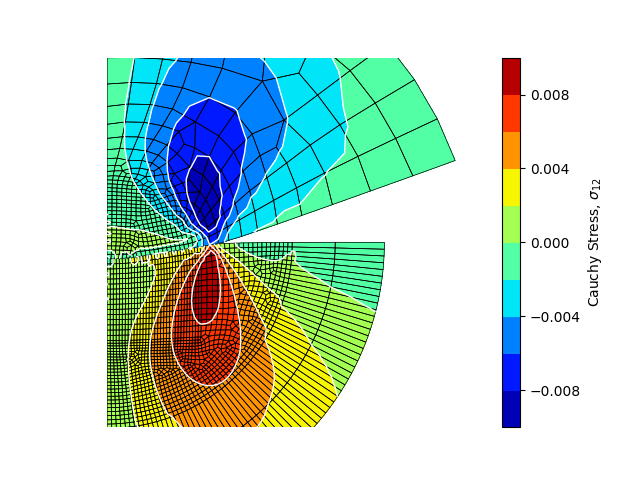

In [18]:
parts = {k:part.mesh.copy() for k, part in model.parts.items() }

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect("equal")
ax.set_xlim(0., 4.)
ax.set_ylim(-2., 2.)

field_num = 14 
disp_num = 15
levels = np.linspace(-1.e-2, 1.e-2, 11)

for k, mesh in parts.items():
    field = mesh.fields[field_num].data.v12
    disp = mesh.fields[disp_num].data
    mesh.nodes[("coords", "x")] += disp.v1
    mesh.nodes[("coords", "y")] += disp.v2
    tri = mesh.to_triangulation()
    patches = mesh.to_polycollection(facecolor = "none",
                                     edgecolor = "black",
                                     linewidth = .5) 
    
    grad = ax.tricontourf(tri, field, levels, cmap = mpl.cm.jet, alpha = 1.)
    ax.tricontour(tri, field, levels, colors = "white", linewidths = 1.)
    ax.add_collection(patches)
cbar = plt.colorbar(grad)
cbar.set_label("Cauchy Stress, $\sigma_{12}$")
ax.axis("off")
plt.xlabel("$x$")
plt.ylabel("$y$")
#plt.grid()